In [1]:
import os
os.chdir('../')

import warnings
warnings.filterwarnings('ignore')

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import os

!nvidia-smi
os.environ["CUDA_VISIBLE_DEVICES"]="2"

Sun Jan 28 20:09:22 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.223.02   Driver Version: 470.223.02   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100 80G...  Off  | 00000000:1B:00.0 Off |                    0 |
| N/A   47C    P0    71W / 300W |   8265MiB / 80994MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA A100 80G...  Off  | 00000000:1C:00.0 Off |                    0 |
| N/A   

### Model Parts

In [3]:
from model.main.enc_prior_latent_quantizer_dec import Model
from model.encoder.net_64_encoder import Encoder
from model.prior.dalle_rand_prior import Prior
from model.latent.dalle_exclusive3_lse_latent import Latent
from model.quantizer.dalle_nearest_quantizer import Quantizer
from model.decoder.net_64_decoder import Decoder

from tensorboardX import SummaryWriter
from util.util import *

### Model Init.

In [4]:
from easydict import EasyDict
hp = EasyDict()
hp.img_size = 64
hp.n_resblocks = 6
hp.z_dim = 64
hp.n_prior_embeddings = 512
hp.quantize = False
hp.prior_mu = 0.999
hp.z_activation = F.tanh
hp.M = hp.n_prior_embeddings

In [5]:
step = 0
device = 'cuda:0'

model_list = []
optimizer_list = []
for i in range(1):
    model = Model(Encoder(**hp), Prior(**hp), Latent(**hp), Quantizer(**hp), Decoder(**hp))
    model = model.to(device)
    model_list.append(model)
    
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)
    optimizer_list.append(optimizer)

for name, module in model.named_modules():
    if len(name.split('.')) <= 2 and len(name) > 0:
        print(name, get_size(module))

print('done')

encoder 1.2191162109375
encoder.encoder 1.2191162109375
prior 0.126953125
latent 0.001953125
quantizer 0.0
decoder 1.0611686706542969
decoder.decoder 1.0611686706542969
done


### Load

In [6]:
save_dir = '/data/scpark/save/lse/train_dalle/train01.28-1_1e-2/'

!mkdir -p $save_dir
!ls -lt $save_dir

writer = SummaryWriter(save_dir)

if False:
    step, model_list, optimizer_list = load_model_list(save_dir, 660000, model_list, optimizer_list)

total 254832
-rw-rw-r-- 1 scpark scpark   103935  1월 28 20:09 events.out.tfevents.1706440073.GPUSVR11
-rw-rw-r-- 1 scpark scpark  7472764  1월 28 20:08 save_0
-rw-rw-r-- 1 scpark scpark       40  1월 28 20:07 events.out.tfevents.1706439871.GPUSVR11
-rw-rw-r-- 1 scpark scpark 42715069  1월 28 20:01 events.out.tfevents.1706413019.GPUSVR11
-rw-rw-r-- 1 scpark scpark  7477961  1월 28 19:50 save_280000
-rw-rw-r-- 1 scpark scpark  7477961  1월 28 19:34 save_270000
-rw-rw-r-- 1 scpark scpark  7477961  1월 28 19:19 save_260000
-rw-rw-r-- 1 scpark scpark  7477961  1월 28 19:03 save_250000
-rw-rw-r-- 1 scpark scpark  7477961  1월 28 18:48 save_240000
-rw-rw-r-- 1 scpark scpark  7477961  1월 28 18:32 save_230000
-rw-rw-r-- 1 scpark scpark  7477961  1월 28 18:16 save_220000
-rw-rw-r-- 1 scpark scpark  7477961  1월 28 18:01 save_210000
-rw-rw-r-- 1 scpark scpark  7477961  1월 28 17:46 save_200000
-rw-rw-r-- 1 scpark scpark  7477961  1월 28 17:30 save_190000
-rw-rw-r-- 1 scpark scpark  7477961  1월 28 17:15 save_

### Dataset

In [7]:
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import CelebA

class MyCelebA(CelebA):
    """
    A work-around to address issues with pytorch's celebA dataset class.
    
    Download and Extract
    URL : https://drive.google.com/file/d/1m8-EBPgi5MRubrm6iQjafK2QMHDBMSfJ/view?usp=sharing
    """
    
    def _check_integrity(self) -> bool:
        return True

root = '/data'
train_transforms = transforms.Compose([transforms.RandomHorizontalFlip(),
                                       transforms.CenterCrop(148),
                                       transforms.Resize(hp.img_size),
                                       transforms.ToTensor(),])
train_dataset = MyCelebA(root, split='train', transform=train_transforms, download=False)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
print('done')

done


In [8]:
def preprocess(batch):
    x, t = batch
    data = {}
    data['x'] = x.to(device)
    data['t'] = t.to(device)
    return data

### Train

In [9]:
def plot(x):
    _x = x.permute(0, 2, 3, 1).data.cpu().numpy()
    plt.figure(figsize=[18, 4])
    for i in range(8):
        plt.subplot(1, 8, i+1)
        plt.imshow(_x[i])
        plt.xticks([])
        plt.yticks([])
    plt.show()

In [10]:
def linear(start_value, end_value, current_index, start_index, end_index):
    if current_index > end_index:
        return end_value
    if current_index < start_index:
        return start_value

    grad = (end_value - start_value) / (end_index - start_index)
    y = start_value + grad * (current_index - start_index)

    return y

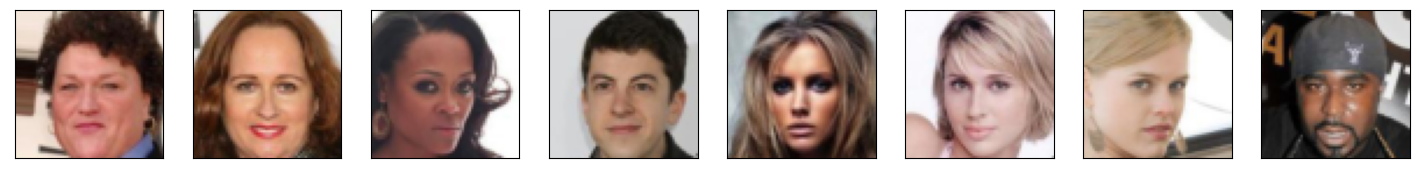

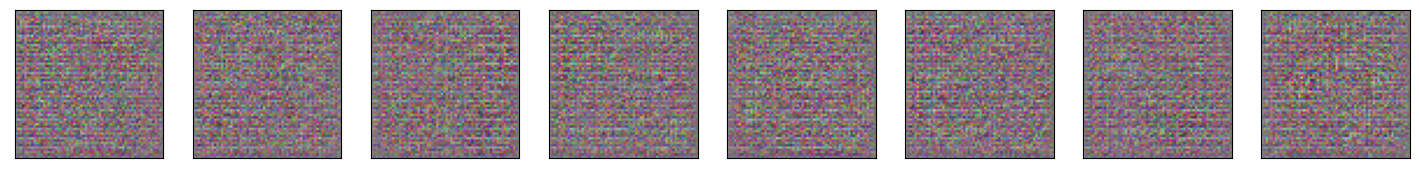

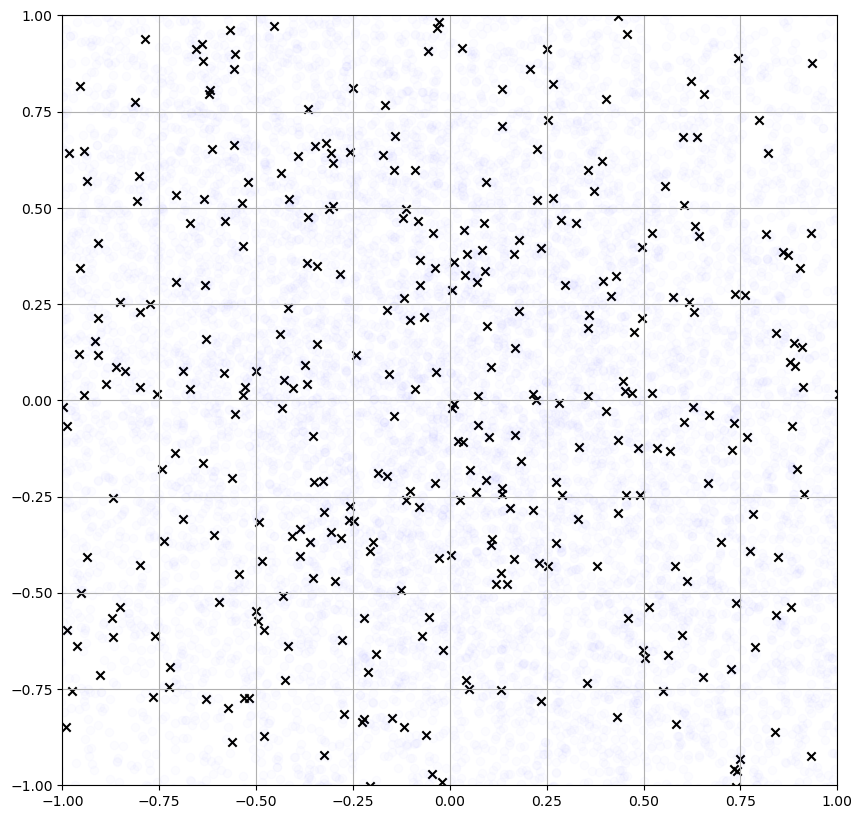

1
lse_loss 32.664794921875
commit_loss 0.6417409181594849
recon_loss 0.0955357551574707
2
lse_loss 32.06450653076172
commit_loss 0.6311089992523193
recon_loss 0.09607704728841782
3
lse_loss 31.24639892578125
commit_loss 0.6173514127731323
recon_loss 0.09366534650325775
4
lse_loss 30.638641357421875
commit_loss 0.6068103313446045
recon_loss 0.09027644246816635
5
lse_loss 29.807151794433594
commit_loss 0.5958456993103027
recon_loss 0.09675400704145432
6
lse_loss 29.41366195678711
commit_loss 0.5883074998855591
recon_loss 0.08764155209064484
7
lse_loss 28.74097442626953
commit_loss 0.5794723033905029
recon_loss 0.08874213695526123
8
lse_loss 27.921161651611328
commit_loss 0.5710494518280029
recon_loss 0.08420844376087189
9
lse_loss 27.212074279785156
commit_loss 0.5646944046020508
recon_loss 0.08407475054264069
10
lse_loss 26.78510284423828
commit_loss 0.558804988861084
recon_loss 0.08540970087051392
11
lse_loss 26.102136611938477
commit_loss 0.5554145574569702
recon_loss 0.07781516760587

lse_loss 6.286033630371094
commit_loss 0.2284199595451355
recon_loss 0.026720747351646423
91
lse_loss 6.089529991149902
commit_loss 0.22849932312965393
recon_loss 0.024556264281272888
92
lse_loss 6.222232818603516
commit_loss 0.22569100558757782
recon_loss 0.024552375078201294
93
lse_loss 6.059866905212402
commit_loss 0.22498837113380432
recon_loss 0.025939546525478363
94
lse_loss 6.149285316467285
commit_loss 0.22539465129375458
recon_loss 0.02471742033958435
95
lse_loss 6.050395965576172
commit_loss 0.22443756461143494
recon_loss 0.02577526867389679
96
lse_loss 5.991209030151367
commit_loss 0.21709893643856049
recon_loss 0.025803055614233017
97
lse_loss 6.009615898132324
commit_loss 0.21891847252845764
recon_loss 0.02510603331029415
98
lse_loss 6.010036468505859
commit_loss 0.2179611325263977
recon_loss 0.025954347103834152
99
lse_loss 6.2198262214660645
commit_loss 0.23469623923301697
recon_loss 0.02550498954951763
100
lse_loss 6.06023645401001
commit_loss 0.20943298935890198
recon_

178
lse_loss 5.894371509552002
commit_loss 0.16600191593170166
recon_loss 0.014694149605929852
179
lse_loss 5.875382423400879
commit_loss 0.1603485643863678
recon_loss 0.013493558391928673
180
lse_loss 5.920842170715332
commit_loss 0.15708939731121063
recon_loss 0.014509047381579876
181
lse_loss 5.950289249420166
commit_loss 0.1621178537607193
recon_loss 0.013852512463927269
182
lse_loss 5.9223737716674805
commit_loss 0.1549132764339447
recon_loss 0.01425743754953146
183
lse_loss 5.881107330322266
commit_loss 0.1609468162059784
recon_loss 0.014097301289439201
184
lse_loss 5.903308868408203
commit_loss 0.15990108251571655
recon_loss 0.014198774471879005
185
lse_loss 5.98393440246582
commit_loss 0.1585271805524826
recon_loss 0.015505610033869743
186
lse_loss 5.968991279602051
commit_loss 0.1590551733970642
recon_loss 0.014521080069243908
187
lse_loss 5.922324180603027
commit_loss 0.16068004071712494
recon_loss 0.014403010718524456
188
lse_loss 6.032450199127197
commit_loss 0.164448738098

lse_loss 6.659908294677734
commit_loss 0.13767355680465698
recon_loss 0.011306989006698132
266
lse_loss 6.680229187011719
commit_loss 0.1366322785615921
recon_loss 0.011317593976855278
267
lse_loss 6.627077102661133
commit_loss 0.13438573479652405
recon_loss 0.012095394544303417
268
lse_loss 6.6032609939575195
commit_loss 0.12749627232551575
recon_loss 0.011919225566089153
269
lse_loss 6.673062324523926
commit_loss 0.13777852058410645
recon_loss 0.010939672589302063
270
lse_loss 6.644370079040527
commit_loss 0.12601181864738464
recon_loss 0.01344711147248745
271
lse_loss 6.732443809509277
commit_loss 0.1425797939300537
recon_loss 0.011872261762619019
272
lse_loss 6.622613906860352
commit_loss 0.13196855783462524
recon_loss 0.010967288166284561
273
lse_loss 6.745108604431152
commit_loss 0.13599076867103577
recon_loss 0.010933044366538525
274
lse_loss 6.650602340698242
commit_loss 0.13402920961380005
recon_loss 0.012503149919211864
275
lse_loss 6.686239242553711
commit_loss 0.12770044803

353
lse_loss 7.518441200256348
commit_loss 0.1078285202383995
recon_loss 0.009094279259443283
354
lse_loss 7.507912635803223
commit_loss 0.10952091217041016
recon_loss 0.008555479347705841
355
lse_loss 7.5498948097229
commit_loss 0.10640250146389008
recon_loss 0.00933077558875084
356
lse_loss 7.599360942840576
commit_loss 0.11795656383037567
recon_loss 0.010161248967051506
357
lse_loss 7.514812469482422
commit_loss 0.09988553822040558
recon_loss 0.007869990542531013
358
lse_loss 7.605175018310547
commit_loss 0.11679930239915848
recon_loss 0.009752137586474419
359
lse_loss 7.693657875061035
commit_loss 0.12064328789710999
recon_loss 0.009222090244293213
360
lse_loss 7.655694961547852
commit_loss 0.11505676805973053
recon_loss 0.009665361605584621
361
lse_loss 7.664275169372559
commit_loss 0.11186344921588898
recon_loss 0.008943594060838223
362
lse_loss 7.659578800201416
commit_loss 0.10965609550476074
recon_loss 0.009206064976751804
363
lse_loss 7.6478376388549805
commit_loss 0.10949903

In [ ]:
from IPython import display

while True:
    for batch in train_loader:
        print(step)
        
        loss_dict = {}
        for model, optimizer in zip(model_list, optimizer_list):
            data = preprocess(batch)

            # Forward
            model.train()
            model.zero_grad()
            distance_p = linear(1, 0.2, step, 0, 1000*1000)
            data = model(data, distance_p=distance_p)

            # Backward
            loss = 0
            for key in data.keys():
                if 'lse_loss' in key:
                    loss = loss + data[key] * 1e-2
                    if key in loss_dict:
                        loss_dict[key].append(data[key].item())
                    else:
                        loss_dict[key] = [data[key].item()]
                elif 'commit_loss' in key:
                    loss = loss + data[key] * 0
                    if key in loss_dict:
                        loss_dict[key].append(data[key].item())
                    else:
                        loss_dict[key] = [data[key].item()]        
                elif 'loss' in key:
                    loss = loss + data[key]
                    if key in loss_dict:
                        loss_dict[key].append(data[key].item())
                    else:
                        loss_dict[key] = [data[key].item()]
                    
            loss.backward()
            optimizer.step()
            
        for key in loss_dict:
            writer.add_scalar(key, np.mean(loss_dict[key]), step)
            print(key, np.mean(loss_dict[key]))
        
        if step % 1000 == 0:
            
            usage = ((data['belong'].sum(dim=0) > 0).sum() / hp.M).item()
            writer.add_scalar('usage', usage, step)            

            import matplotlib.pyplot as plt
            display.clear_output()
            
            x = data['x']
            y = data['y']
            
            plot(x)
            plot(y)
                        
            from sklearn.decomposition import PCA
            pca = PCA(n_components=2)
            e = model.prior.prior.data.cpu().numpy()
            pca.fit(e)
            e_pca = pca.transform(e)
            z_pca = pca.transform(data['z'].permute(0, 2, 3, 1).reshape(-1, hp.z_dim).data.cpu().numpy())
            plt.figure(figsize=[10, 10])
            plt.scatter(e_pca[:, 0], e_pca[:, 1], marker='x', alpha=1.0, color='black')
            plt.scatter(z_pca[:, 0], z_pca[:, 1], marker='o', alpha=0.01, color='blue')
            plt.xlim([-1, 1])
            plt.ylim([-1, 1])
            plt.grid()
            plt.show() 
            
        if step % 10000 == 0:
            save_model_list(save_dir, step, model_list, optimizer_list)
                
        step += 1
        

In [ ]:
save_model_list(save_dir, step, model_list, optimizer_list)
print('done')